# Smart Crop Selection: Using Machine Learning to Optimize Farming Decisions

![Farmer in a field](crop_selection_smart_farming.png)

Choosing the right crop to plant each season is a crucial decision for farmers aiming to maximize their yield and profitability. Soil health plays a significant role in crop growth, with factors such as nitrogen, phosphorus, potassium levels, and soil pH having a direct impact on productivity. However, assessing soil conditions can be expensive and time-consuming, leading farmers to prioritize certain metrics based on budget constraints.

The goal is to develop an accurate predictive model that can analyze soil composition and recommend the most suitable crop for optimal yield.

The dataset used for this project, `soil_measures.csv`, contains key soil metrics collected from various fields. Each row in the dataset represents a set of soil measurements and the corresponding crop that is best suited for those conditions. The features included in the dataset are:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"ph"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

In [46]:
# All required libraries are imported here for you.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns 


In [31]:
# Load dataset
df = pd.read_csv('soil_measures.csv')

Original dataset size: 2200
Cleaned dataset size: 2000
Number of rows removed: 200


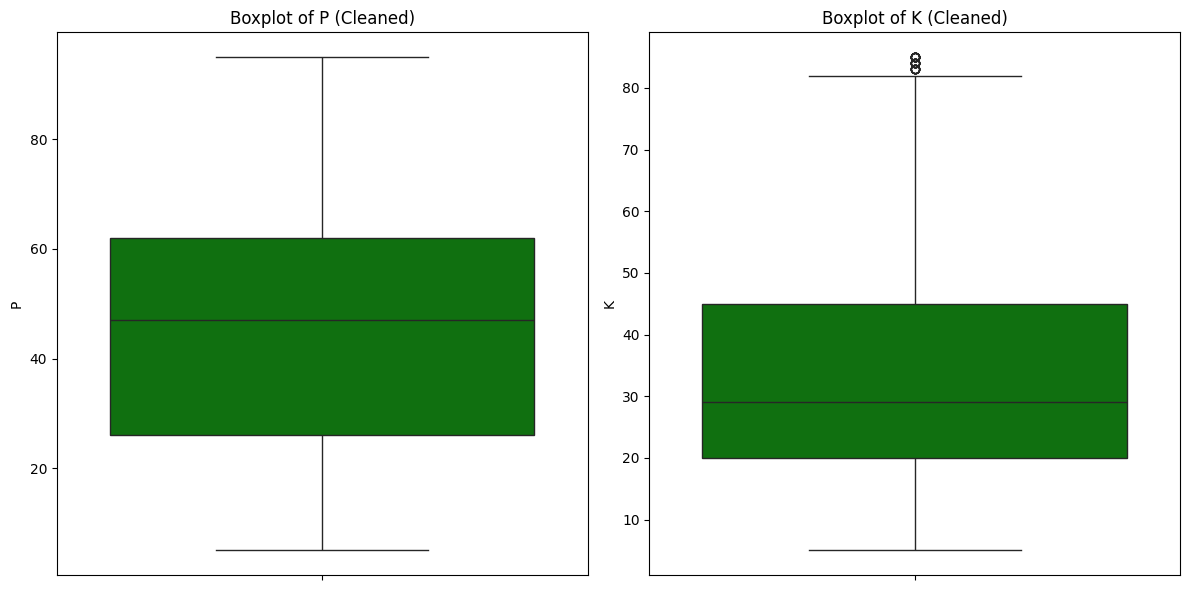

In [32]:
# Define numerical features to check for outliers
numerical_features = ['P', 'K']

# Function to remove outliers using IQR
def remove_outliers_iqr(data, columns):
    df_cleaned = data.copy()
    for col in columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    return df_cleaned

# Remove outliers from all numerical features
df_cleaned = remove_outliers_iqr(df, numerical_features)

# Print the number of rows removed
print(f"Original dataset size: {df.shape[0]}")
print(f"Cleaned dataset size: {df_cleaned.shape[0]}")
print(f"Number of rows removed: {df.shape[0] - df_cleaned.shape[0]}")

# Plot boxplots for cleaned data
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, len(numerical_features), i)
    sns.boxplot(y=df_cleaned[feature], color='green')
    plt.title(f'Boxplot of {feature} (Cleaned)')
plt.tight_layout()
plt.show()

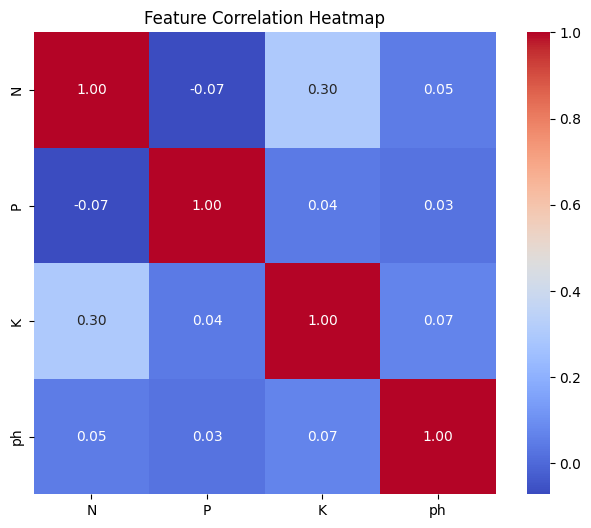

In [33]:
# Step 2: Analyze the correlation between features using a heatmap
numerical_features = ['N', 'P', 'K', 'ph']
correlation_matrix = df_cleaned[numerical_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.show()

Class distribution:
crop
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
watermelon     100
muskmelon      100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64
The dataset is relatively balanced.


C:\Users\tungv\AppData\Local\Temp\ipykernel_33744\3635205155.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette='viridis')


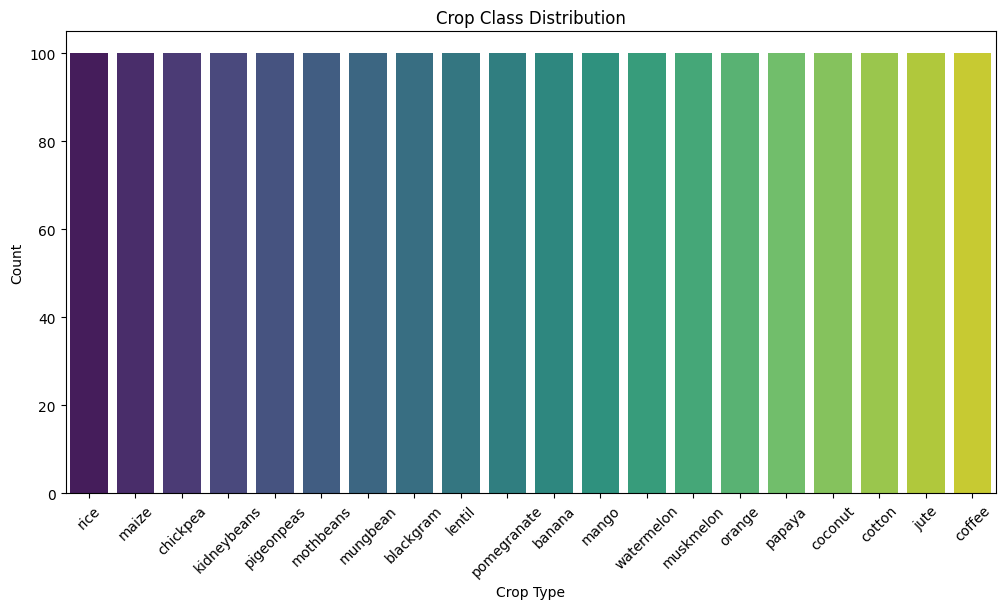

In [45]:
# Count occurrences of each crop category
target_counts = df_cleaned['crop'].value_counts()

# Print class distribution
print("Class distribution:")
print(target_counts)

# Check if the dataset is balanced
max_count = target_counts.max()
min_count = target_counts.min()
balance_ratio = min_count / max_count

if balance_ratio > 0.8:
    print("The dataset is relatively balanced.")
else:
    print("The dataset is imbalanced.")

# Plot the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=target_counts.index, y=target_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Crop Class Distribution')
plt.xlabel('Crop Type')
plt.ylabel('Count')
plt.show()


In [34]:
# Feature and target selection
X = df_cleaned[['N', 'P', 'K', 'ph']]
y = df_cleaned['crop']

In [35]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Preprocessing: Standardize numerical features
numerical_features = ['N', 'P', 'K', 'ph']
X[numerical_features] = X[numerical_features].astype('float64')
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_features] = scaler.fit_transform(X[numerical_features])

# print(X_scaled.dtypes)
# print(X_scaled.head())

C:\Users\tungv\AppData\Local\Temp\ipykernel_33744\3767542129.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_features] = X[numerical_features].astype('float64')


In [36]:
# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [41]:
# Define parameter grids for XGBoost and LightGBM
xgb_params = {
    'max_depth': [10, 20],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.7, 0.9]
}

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [42]:
# Perform hyperparameter tuning using cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost tuning
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss',verbosity=1)
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=xgb_params, cv=kf, scoring='accuracy', n_jobs=1, verbose=1)
xgb_grid.fit(X_train, y_train)

# Hyperparameter tuning for KNN
knn_model = KNeighborsClassifier()
knn_grid_search = GridSearchCV(estimator=knn_model, param_grid=knn_param_grid, cv=kf, scoring='accuracy', n_jobs=1, verbose=1)
knn_grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

XGBoost Macro F1-Score: 0.8212918986738382
XGBoost Accuracy: 0.8300
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 100, 'subsample': 0.9}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.65      0.85      0.74        20
           2       1.00      1.00      1.00        20
           3       0.85      0.85      0.85        20
           4       0.95      0.95      0.95        20
           5       0.95      1.00      0.98        20
           6       0.58      0.75      0.65        20
           7       0.80      1.00      0.89        20
           8       0.67      0.50      0.57        20
           9       1.00      1.00      1.00        20
          10       0.94      0.75      0.83        20
          11       0.85      0.85      0.85        20
          12       0.74      1.00      0.85        20
          13       0.65      0.75      0.70

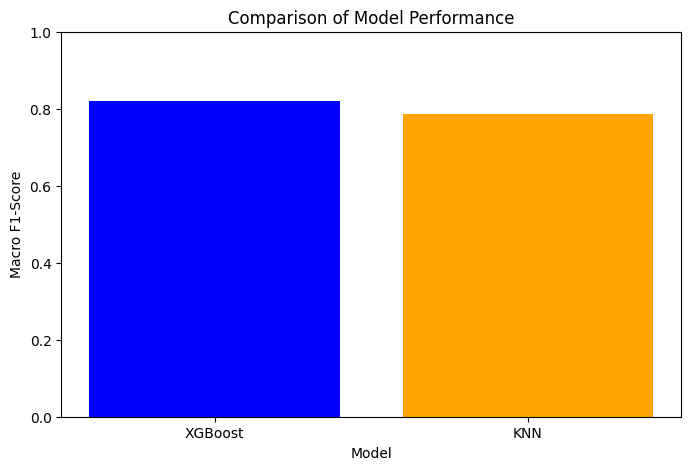

In [48]:
# Evaluate models
xgb_best_model = xgb_grid.best_estimator_
xgb_pred = xgb_best_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred, average='macro')

print("XGBoost Macro F1-Score:", xgb_f1)
print(f'XGBoost Accuracy: {xgb_accuracy:.4f}')
print(f"Best parameters for XGBoost: {xgb_grid.best_params_}")
print(f"Classification Report:\n{classification_report(y_test, xgb_pred)}")

best_knn_model = knn_grid_search.best_estimator_
knn_pred = best_knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred, average='macro')

print("KNN Macro F1-Score:", knn_f1)
print("Best parameters for KNN:", knn_grid_search.best_params_)
print("KNN Accuracy:", knn_accuracy)
print(classification_report(y_test, knn_pred))

# Plot comparison of macro F1-scores
models = ['XGBoost', 'KNN']
f1_scores = [xgb_f1, knn_f1]

plt.figure(figsize=(8, 5))
plt.bar(models, f1_scores, color=['blue', 'orange'])
plt.xlabel('Model')
plt.ylabel('Macro F1-Score')
plt.title('Comparison of Model Performance')
plt.ylim(0, 1)
plt.show()

<Figure size 1000x600 with 0 Axes>

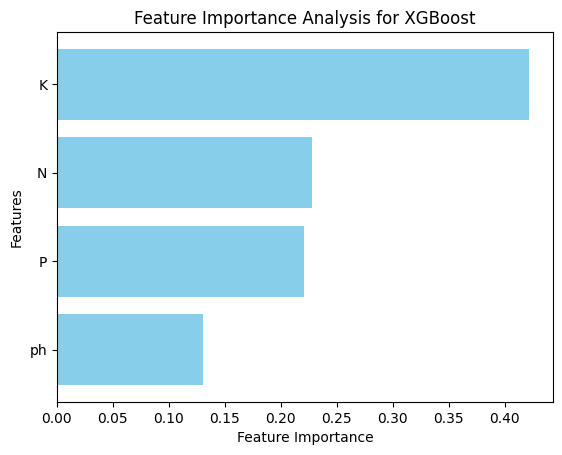

In [23]:

# Get feature importance from the XGBoost model
feature_importance = xgb_best_model.feature_importances_
feature_names = X_train.columns

# Create a sorted index for the features by importance
sorted_idx = np.argsort(feature_importance)[::-1]

# Sort feature names and importance values for plotting
sorted_feature_names = feature_names[sorted_idx]
sorted_feature_importance = feature_importance[sorted_idx]

# Plot the feature importance as a bar chart
plt.figure(figsize=(10, 6))
plt.figure()
plt.barh(sorted_feature_names, sorted_feature_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Analysis for XGBoost')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
plt.show()